In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('test.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
%%javascript
Jupyter.notebook.execute_cells([1])
console.log("Somethi ng")

In [7]:
%matplotlib notebook
# import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from numpy import random 
from matplotlib.widgets import Button
from matplotlib.backend_bases import MouseEvent
import math
import pickle
import pandas as pd
from IPython.display import Javascript

class FinalPlotInstance(object):
    def __init__(self, filename, tasktype, anitype, outfilename, showanswer, figure, plotnum):
        self.filename = filename
        self.anitype = anitype
        self.tasktype = tasktype
        self.outfilename = outfilename
        self.showanswer = showanswer
        
        self.readfromfile(filename)

        self.fig = figure#plt.figure()
        self.ax = plt.axes(xlim=self.xlim, ylim=self.ylim)
        plt.gca().axes.set_aspect('equal', 'box')
        self.line, = self.ax.plot([], [], lw=2)

        self._dragging_point = None
        self._segments = []
        self._lines = [None, None, None]

        self.plotlays = self.N
        self.lines = []
        self.numclicks = 0
        self.enable_clicks = 0
        self.annotation = None

        for index in range(self.N):
            lobj = self.ax.plot([],[],lw=2,color='lightgrey')[0]
            self.lines.append(lobj)
    
        for index in range(self.N):
            lobj = self.ax.plot([],[],color='darkgrey', marker='o', markeredgecolor='darkgrey')[0]
            self.lines.append(lobj)
            
        self.frame_num = 200
        self.dots = 200
        if self.anitype == 1:
            self.TAIL_LEN = 0
        elif self.anitype == 2 or self.anitype == 4:
            self.TAIL_LEN = 0.5
        else:
            self.TAIL_LEN = 1
        
        # call the animator.  blit=True means only re-draw the parts that have changed.
        self.anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init_anim,
                               frames=self.frame_num, interval=10, blit=True, repeat=False)

        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)

        # anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

        axnext = plt.axes([0.81, 0.45, 0.1, 0.075])
        self.bnext = Button(axnext, 'Submit')
        self.bnext.on_clicked(self.graph_submit)
        
        if showanswer:
            axshow = plt.axes([0.81, 0.55, 0.1, 0.075])
            self.bshow = Button(axshow, 'Show\nanswer')
            self.bshow.on_clicked(self.show_answer)
            
            axresrart= plt.axes([0.81, 0.65, 0.1, 0.075])
            self.brestart = Button(axresrart, 'Restart')
            self.brestart.on_clicked(self.restart_on_button)

        plt.sca(self.ax)
#         plt.show()
        

    def readfromfile(self, filename):
        #read ftom file: xlim, ylim, tasktype, N, x, y, xfin, yfin
        f = open(filename, "rb")
        self.N, self.Nnorm, self.Nopp, self.Nlong, self.Nside, bottom, top = pickle.load(f)
        self.basis = pickle.load(f)
        self.x = pickle.load(f)
        self.y = pickle.load(f)
        self.xfin = pickle.load(f)
        self.yfin = pickle.load(f)
        f.close()

        self.xlim = (bottom, top)
        self.ylim = (bottom, top)
        
        
    def restart_on_button(self, event):
        pfile("anim called")
        self.restart()
        
    def show_answer(self, event):
        if self.numclicks == 2:
            #TODO: draw answer
            if self.anitype == 1:
                rang = range(self.Nnorm, self.Nnorm + self.Nopp)
            elif self.anitype == 2:
                rang = range(self.Nnorm + self.Nopp, self.Nnorm + self.Nopp + self.Nlong)
            else:
                rang = range(self.Nnorm + self.Nopp + self.Nlong, self.N)
            for i in rang:
                # data
                df=pd.DataFrame({'x': [self.x[i], self.xfin[i]], 'vertical': [self.y[i], self.yfin[i]] })
 
                # plot
                plt.plot( 'x', 'vertical', color='green', data=df, linestyle='-', marker='o', alpha = 0.3)
        
    def graph_submit(self, event):
        if self.numclicks == 2:
            df = []
            if self.anitype == 1:
                rang = range(self.Nnorm, self.Nnorm + self.Nopp)
            elif self.anitype == 2:
                rang = range(self.Nnorm + self.Nopp, self.Nnorm + self.Nopp + self.Nlong)
            else:
                rang = range(self.Nnorm + self.Nopp + self.Nlong, self.N)
            for i in rang:
                # data
                df.append([(self.x[i], self.y[i]), (self.xfin[i], self.yfin[i])] )
                
                
            plt.clf()
            
            f = open(self.outfilename, "wb")
            pickle.dump(self.filename, f)
            pickle.dump(self.outfilename, f)
            pickle.dump(self.anitype, f)
            pickle.dump(self.tasktype, f)
            pickle.dump(df, f)
            pickle.dump(self._segments, f)
            f.close()
            ##################
#             Javascript("Jupyter.notebook.execute_cells([5])")
#             %%javascript
#             Jupyter.notebook.execute_cells([5])
#             FinalPlotInstance("2.txt", 3, 2, "2.out", True, figure)
#             plt.close()
    
    def init_anim(self):
        for line in self.lines:
            line.set_data([],[])
        return self.lines

    
    def animate(self, i):
        time = (i%(self.frame_num))/(self.frame_num*1.0)
    
    
        xs = []
        ys = []
        if self.anitype == 4:
            for j in range(self.N):

                vectorLen = math.sqrt((self.xfin[j]-self.x[j])*(self.xfin[j]-self.x[j]) + (self.yfin[j]-self.y[j])*(self.yfin[j]-self.y[j]))
                basLen = math.sqrt(self.basis[0]*self.basis[0] + self.basis[1]*self.basis[1])

                deltahead = time*(1+basLen*self.TAIL_LEN/vectorLen)
                if deltahead > 1:
                    deltahead = 1

                deltatail = time*(1+basLen*self.TAIL_LEN/vectorLen)-basLen*self.TAIL_LEN/vectorLen
                if deltatail < 0:
                    deltatail = 0


                xs.append(np.linspace(self.x[j]+(self.xfin[j]-self.x[j])*deltatail, self.x[j]+(self.xfin[j]-self.x[j])*deltahead, self.dots))
                ys.append(np.linspace(self.y[j]+(self.yfin[j]-self.y[j])*deltatail, self.y[j]+(self.yfin[j]-self.y[j])*deltahead, self.dots))
            for j in range(self.N):
                vectorLen = math.sqrt((self.xfin[j]-self.x[j])*(self.xfin[j]-self.x[j]) + (self.yfin[j]-self.y[j])*(self.yfin[j]-self.y[j]))

                deltahead = time*(1+basLen*self.TAIL_LEN/vectorLen)
                if deltahead > 1:
                    deltahead = 1
                xs.append(self.x[j]+(self.xfin[j]-self.x[j])*deltahead)
                ys.append(self.y[j]+(self.yfin[j]-self.y[j])*deltahead)
        else:
            headtime = time*(1+self.TAIL_LEN)
            tailtime = time*(1+self.TAIL_LEN)-self.TAIL_LEN
            if headtime > 1:
                headtime = 1
            if tailtime < 0:
                tailtime = 0

            for j in range(self.N):
                xs.append(np.linspace(self.x[j]+(self.xfin[j]-self.x[j])*tailtime, self.x[j]+(self.xfin[j]-self.x[j])*headtime, self.dots))
                ys.append(np.linspace(self.y[j]+(self.yfin[j]-self.y[j])*tailtime, self.y[j]+(self.yfin[j]-self.y[j])*headtime, self.dots))

            for j in range(self.N):
                xs.append(self.x[j]+(self.xfin[j]-self.x[j])*headtime)
                ys.append(self.y[j]+(self.yfin[j]-self.y[j])*headtime)
      
        for lnum,line in enumerate(self.lines):
            line.set_data(xs[lnum], ys[lnum])
        
        if i == self.frame_num-1 and self.numclicks == 0:
            self.anim.event_source.stop()
            self.annotation = self.ax.annotate('Click when you are ready to replay', (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top')
            self.fig.canvas.mpl_connect('button_press_event', self.onClick)
            self.enable_clicks = 1
        else:
            if i == self.frame_num-1 and self.showanswer:
                self.anim.event_source.stop()
            
            if i == self.frame_num-1:
                self.enable_clicks = 1 
                self.annotation.remove()
                self.annotation = self.ax.annotate('Click to see the question', (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top')
        
        return self.lines


    def onClick(self, event):
        if not self.enable_clicks:
            return;
    
        if self.numclicks == 0:
            self.numclicks = 1
            self.restart()
            self.enable_clicks = 0
        else:
            if self.numclicks == 1:
                self.numclicks = self.numclicks + 1
                
                self.start_picking()
            else:
                # left click
                if event.button == 1 and event.inaxes in [self.ax]:
                    point = self._find_neighbor_point(event)
                    if point:
                        self._dragging_point = (point[0], point[1])
                        self._replace_point(point[0], point[1], event.xdata, event.ydata)
                    else:
                        self._add_point(event)
                        self._update_plot()
                    
                elif event.button == 3 and event.inaxes in [self.ax]:
                    point = self._find_neighbor_point(event)
                    if point:
                        self._remove_segment(point[0])
                        self._update_plot()
                        

    def _update_plot(self):
        if not self._segments:
            for i in range(0, 3):
                if self._lines[i]:
                    self._lines[i].set_data([0], [0])
                    self._lines[i].set_alpha(0.0)
                self.fig.canvas.draw()
                return
        
        for num,segment in enumerate(self._segments):
            xseg = []
            yseg = []
            for pair in segment:
                xseg.append(pair[0])
                yseg.append(pair[1])
            
            if not self._lines[num]:
                self._lines[num], = self.ax.plot(xseg, yseg, "b", marker="o", markersize=5)
        
            # Update current plot
            else:
                self._lines[num].set_data(xseg, yseg)
                self._lines[num].set_alpha(1.0)
                
        
        
        for i in range(num+1, 3):
            if self._lines[i]:
                self._lines[i].set_data([0], [0])
                self._lines[i].set_alpha(0.0)
            
        self.fig.canvas.draw()
            
            
    def _add_point(self, xloc, yloc=None):
        if isinstance(xloc, MouseEvent):
            xloc, yloc = xloc.xdata, xloc.ydata
            if not self._segments:
                self._segments.append([(xloc,yloc)])
            
                return xloc, yloc
            for segment in self._segments:
                if len(segment) < 2:
                    segment.append((xloc,yloc))

                    return xloc, yloc
            if len(self._segments) < 3:
                self._segments.append([(xloc,yloc)])
        return xloc, yloc
    
    
    def _remove_segment(self, segnum):
        del self._segments[segnum]
    
    
    def _replace_point(self, segindex, index, xnew, ynew):
        self._segments[segindex][index] = (xnew,ynew)
            
            
    def _find_neighbor_point(self, event):
        distance_threshold = 0.03
        nearest_point = None
        min_distance = 10
        for snum,segment in enumerate(self._segments):
            for pnum,pair in enumerate(segment):
                distance = math.hypot(event.xdata - pair[0], event.ydata - pair[1])
                
                if distance < min_distance:
                    min_distance = distance
                    nearest_point = (snum, pnum)
                if min_distance < distance_threshold:
                    return nearest_point
        return None
    
    def restart(self):
        pfile("restart")
        self.anim.frame_seq = self.anim.new_frame_seq() 
        self.anim.event_source.start()
    
    def start_picking(self):
        self.annotation.remove()
        if self.tasktype == 1:
            self.annotation = self.ax.annotate('Draw trajectories of the dots moving to the opposite\n direction than the main trend', (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top')
        elif self.tasktype == 2:
            self.annotation = self.ax.annotate('Draw trajectories of the dots that travel a distance\n longer than average motion', (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top')
        else:
            self.annotation = self.ax.annotate('Draw trajectories of the dots moving to sideways\n from the main trend', (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top')
        
        self.fig.canvas.mpl_connect('button_release_event', self._on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self._on_motion)
     
    def _on_release(self, event):
        if event.button == 1 and event.inaxes in [self.ax] and self._dragging_point:
            self._replace_point(self._dragging_point[0], self._dragging_point[1], event.xdata, event.ydata)
            self._dragging_point = None
            self._update_plot()
    
    def _on_motion(self, event):
        return
#     if not _dragging_point:
#         return
#     _replace_point(_dragging_point[0], _dragging_point[1], event.xdata, event.ydata)
#     _update_plot()
    
def pfile(stringa):
    f= open("error.txt","a")
    f.write("\n")
    f.write(stringa)
    f.close() 



Traceback (most recent call last):
  File "/home/sashtsvet/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/sashtsvet/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


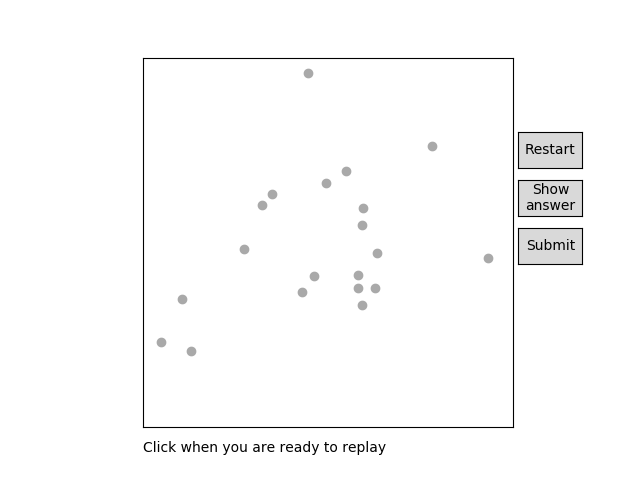

In [8]:
#filename, tasktype, anitype, outfilename, showanswer

figure = plt.figure()

plot = FinalPlotInstance("1.txt", 2, 2, "1.out", True, figure, 0)

    
    


In [ ]:
plot = FinalPlotInstance("2.txt", 3, 2, "2.out", True, figure)

# Information Visualization study

Hi!

Thank you for patricipating in my research. I am looking at different ways of dots movement animation.
I will show you around 60 graphs and ask you to draw a few lines.

Let's take a look at the animation. Just play the video below.

In [ ]:
video = io.open('animation.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

There will always be 20 dots moving around.

13 dots are moving in a similar direction and they are travelling the same distance. We call it "the main trend".

The other dots are either moving to another direction or travel a different distance.

In [ ]:
video = io.open('animation_main.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Some dots move to the opposite direction

In [ ]:
video = io.open('animation_opp.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Some dots travel a longer distance

In [ ]:
video = io.open('animation_long.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

You will have 3 types of questions:
        * Draw trajectories of the dots moving to the opposite direction than the main trend
        * Draw trajectories of the dots that travel a distance longer than average motion
        * Draw trajectories of the dots moving to sideways from the main trend

Each question has 1 to 3 right answers

Try to do your best answering the question

In the experiment you will be able to play animation twice. The first run starts automatically, for the second run you have to click on the window.

After watching the animation for the second time, click again to see the question. Questions appear on the bottom.

To answer the question left-click at the begining and the end of the dot trajectory. You can add up to 3 trajectories. Single dots don't count as an answer.

To edit your answer drag the end of the trajectory with a mouse. You can also delete a trajectory with left click.

When you are done, press "Submit" button to see the next task.

Press "Start" to start the experiment.

You will have 3 practice tasks before the real experiment. In these tasks you can replay animation as many times as you wish. You can also show the right answer.

In [ ]:
plot = FinalPlotInstance("1.txt", 2, 2, "1.out", True, figure, 0)